# **Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline**

In this workbook, we implement basic neural network architectures introduced in the paper [1]: a Fully Convolutional Network and a Residual Network.

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.optimizers import Adadelta, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Layer, Dropout, BatchNormalization, Conv1D, MaxPool1D, ReLU, Dense, Flatten, GlobalMaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D

In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

%run ../sys_configs.ipynb
%run ../plots.ipynb

Mounted at /content/drive


In [3]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [4]:
C = len(set(y_train)) # Number of classes

In [5]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.int32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.int32)
test_labels_tf = tf.one_hot(y_test, 31, dtype=tf.int32)

In [6]:
# Convert the dataset to tensors
train_data_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
val_data_tf = tf.convert_to_tensor(x_val, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tf, train_labels_tf))
val_ds = tf.data.Dataset.from_tensor_slices((val_data_tf, val_labels_tf))
test_ds = tf.data.Dataset.from_tensor_slices((test_data_tf, test_labels_tf))

In [8]:
train_ds = train_ds.shuffle(500)

train_ds = train_ds.padded_batch(16)
val_ds = val_ds.padded_batch(16)
test_ds = test_ds.padded_batch(16)

In [9]:
# We use early stopping as InceptionTime is a high parameter network, so requires many epochs to train.
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15)

# The paper also makes use of ReduceLROnPlateau which reduces the lesrning rate when the loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=10e-3)

## **Fully Convolutional Neural Network**

FCNs can be trained pixel-to-pixel for semantic segmentation annotation tasks, in line with the paper. The main idea behind FCNs is that convolutional layers are followed by batch normalisation, then by the ReLU activation function. The kernels used in the convolutions are 1D and they are non-striding. The penultimate step in the network is global max pooling; this requires 0 new weight parameters. This is the step which, more than any other, is the source of the network's name, as it is normal to first flatten the condensed image and then apply a fully connected layer. The final step is a classification layer.



In [10]:
def fcn(shape):
    input_layer = Input(shape=shape)

    # The input time series is multi-dimensional so that the matrix is N x T x D. The Con1D layers preserve the time dimension).
    layer = Conv1D(filters=128, kernel_size=8, padding="same")(input_layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = Conv1D(filters=256, kernel_size=5, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = Conv1D(filters=128, kernel_size=3, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = GlobalAveragePooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [11]:
fcn_model = fcn(shape = (sz, dim))
fcn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 150, 128)            │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 150, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 150, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 150, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,847 (1.05 MB)

 Trainable params: 273,823 (1.04 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [12]:
fcn_model.compile(optimizer=Adam(learning_rate=10e-2, beta_1=0.95, beta_2 = 0.99, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = fcn_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[earlystopping, reduce_lr])

Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2056 - loss: 2.8335 - val_accuracy: 0.4353 - val_loss: 3.1153 - learning_rate: 0.1000
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4453 - loss: 1.5003 - val_accuracy: 0.4461 - val_loss: 2.8042 - learning_rate: 0.1000
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5543 - loss: 1.2090 - val_accuracy: 0.5244 - val_loss: 1.4556 - learning_rate: 0.1000
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5874 - loss: 1.1353 - val_accuracy: 0.6142 - val_loss: 1.4931 - learning_rate: 0.1000
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6298 - loss: 1.0123 - val_accuracy: 0.5876 - val_loss: 1.3039 - learning_rate: 0.1000
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6486 - loss: 0.9311 - val_accuracy: 0.5618 - val_loss: 1.7940 - learning_rate: 0.1000
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6656 - loss: 0.9194 -

In [13]:
fcn_model.save('../models/fcn_model/fcn_model.h5')
with open('../models/fcn_model/train_history.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

In [12]:
# Load the model
fcn_model = load_model('../models/fcn_model/fcn_model.h5')

# Load the training history
with open('../models/fcn_model/train_history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [13]:
# Get the predictions on the validation dataset
fcn_val_results = fcn_model.evaluate(val_ds, batch_size = 128)
fcn_test_results = fcn_model.evaluate(test_ds, batch_size = 128)

print("Validation Loss: {}\nValidation Accuracy: {}".format(*fcn_val_results))
print("Test Loss: {}\nTest Accuracy: {}".format(*fcn_test_results))

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6479 - loss: 1.5916
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5070 - loss: 4.7280
Validation Loss: 1.3350701332092285
Validation Accuracy: 0.6716954112052917
Test Loss: 4.605151653289795
Test Accuracy: 0.5014272332191467


## **ResNet**

The idea behind ResNets is to divide a convolutional network into blocks. Within each block, there is a *shortcut* connection that enables the gradient to flow directly from the block start layer.

A single block is defined from the entire network given in the Fully Connected Network model introduced earlier, and the ResNet stacks 3 such residual blocks.

In [17]:
class ResidualBlock(Layer):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.batch_norm_1 = BatchNormalization()
        self.batch_norm_2 = BatchNormalization()
        self.batch_norm_3 = BatchNormalization()

        self.relu_1 = ReLU()
        self.relu_2 = ReLU()
        self.relu_3 = ReLU()

        self.conv_1 = Conv1D(self.units, kernel_size=8, padding="same")
        self.conv_2 = Conv1D(self.units, kernel_size=5, padding="same")
        self.conv_3 = Conv1D(input_shape[-1], kernel_size=3, padding="same") # Last dimension of the input shape must match with last dimension of output shape

    def call(self, input):
        x = self.conv_1(input)
        x = self.batch_norm_1(x)
        x = self.relu_1(x)

        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.relu_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x)
        x = self.relu_3(x)

        output = x + input
        return output

In [26]:
def resnet(shape):
    input_layer = Input(shape=shape)

    # The input time series is multi-dimensional so that the matrix is N x T x D. The Con1D layers preserve the time dimension).
    layer = ResidualBlock(64, name='block1')(input_layer)
    layer = ResidualBlock(128, name='block2')(layer)
    layer = ResidualBlock(128, name='block3')(layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [27]:
resnet_model = resnet(shape = (sz, dim))
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1 (ResidualBlock)               │ (None, 150, 6)              │          25,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2 (ResidualBlock)               │ (None, 150, 6)              │          91,678 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3 (ResidualBlock)               │ (None, 150, 6)              │          91,678 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 6)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 31)                  │             217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,947 (816.20 KB)

 Trainable params: 207,631 (811.06 KB)

 Non-trainable params: 1,316 (5.14 KB)

In [22]:
resnet_model.compile(optimizer=Adam(learning_rate=10e-1, beta_1=0.95, beta_2 = 0.99, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])
history3 = resnet_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[earlystopping, reduce_lr])

Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.2635 - loss: 8.1714 - val_accuracy: 0.3793 - val_loss: 5.3829 - learning_rate: 1.0000
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3565 - loss: 5.6538 - val_accuracy: 0.3362 - val_loss: 6.9018 - learning_rate: 1.0000
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3575 - loss: 6.4712 - val_accuracy: 0.3693 - val_loss: 7.0370 - learning_rate: 1.0000
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3606 - loss: 6.8065 - val_accuracy: 0.3082 - val_loss: 7.9208 - learning_rate: 1.0000
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3627 - loss: 6.0327 - val_accuracy: 0.3606 - val_loss: 7.4643 - learning_rate: 1.0000
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3659 - loss: 5.9639 - val_accuracy: 0.2723 - val_loss: 8.2197 - learning_rate: 1.0000
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3541 - loss: 6.3665 -

In [ ]:
resnet_model.save('../models/resnet_model/resnet_model.h5')
with open('../models/resnet_model/train_history.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
custom_objects = {'ResidualBlock': ResidualBlock}
resnet_model = load_model('../models/resnet_model/resnet_model.h5', custom_objects=custom_objects)

# Load the training history
with open('../models/resnet_model/train_history.pkl', 'rb') as f:
    history3 = pickle.load(f)

In [23]:
# Get the predictions on the validation dataset
resnet_val_results = resnet_model.evaluate(val_ds, batch_size = 128)
resnet_test_results = resnet_model.evaluate(test_ds, batch_size = 128)

print("Validation Loss: {}\nValidation Accuracy: {}".format(*resnet_val_results))
print("Test Loss: {}\nTest Accuracy: {}".format(*resnet_test_results))

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3710 - loss: 4.6888
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3114 - loss: 7.8427
Validation Loss: 5.268787860870361
Validation Accuracy: 0.38002872467041016
Test Loss: 7.390163898468018
Test Accuracy: 0.31493815779685974


## **Visualise predictions for test set**

We visualise the predictions of the best model in this notebook, which was the Fully Connected Network.

In [14]:
fcn_val_predictions = fcn_model.predict(val_data_tf, batch_size = 128)
fcn_test_predictions = fcn_model.predict(test_data_tf, batch_size = 128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


In [15]:
fcn_val_predictions = tf.argmax(fcn_val_predictions, axis = 1).numpy()
fcn_test_predictions = tf.argmax(fcn_test_predictions, axis = 1).numpy()

In [16]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(fcn_val_predictions), sum(np.equal(fcn_val_predictions, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(fcn_test_predictions), sum(np.equal(fcn_test_predictions, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 935
Test Data - Total predictions made: 1051. Number of correct predictions: 527


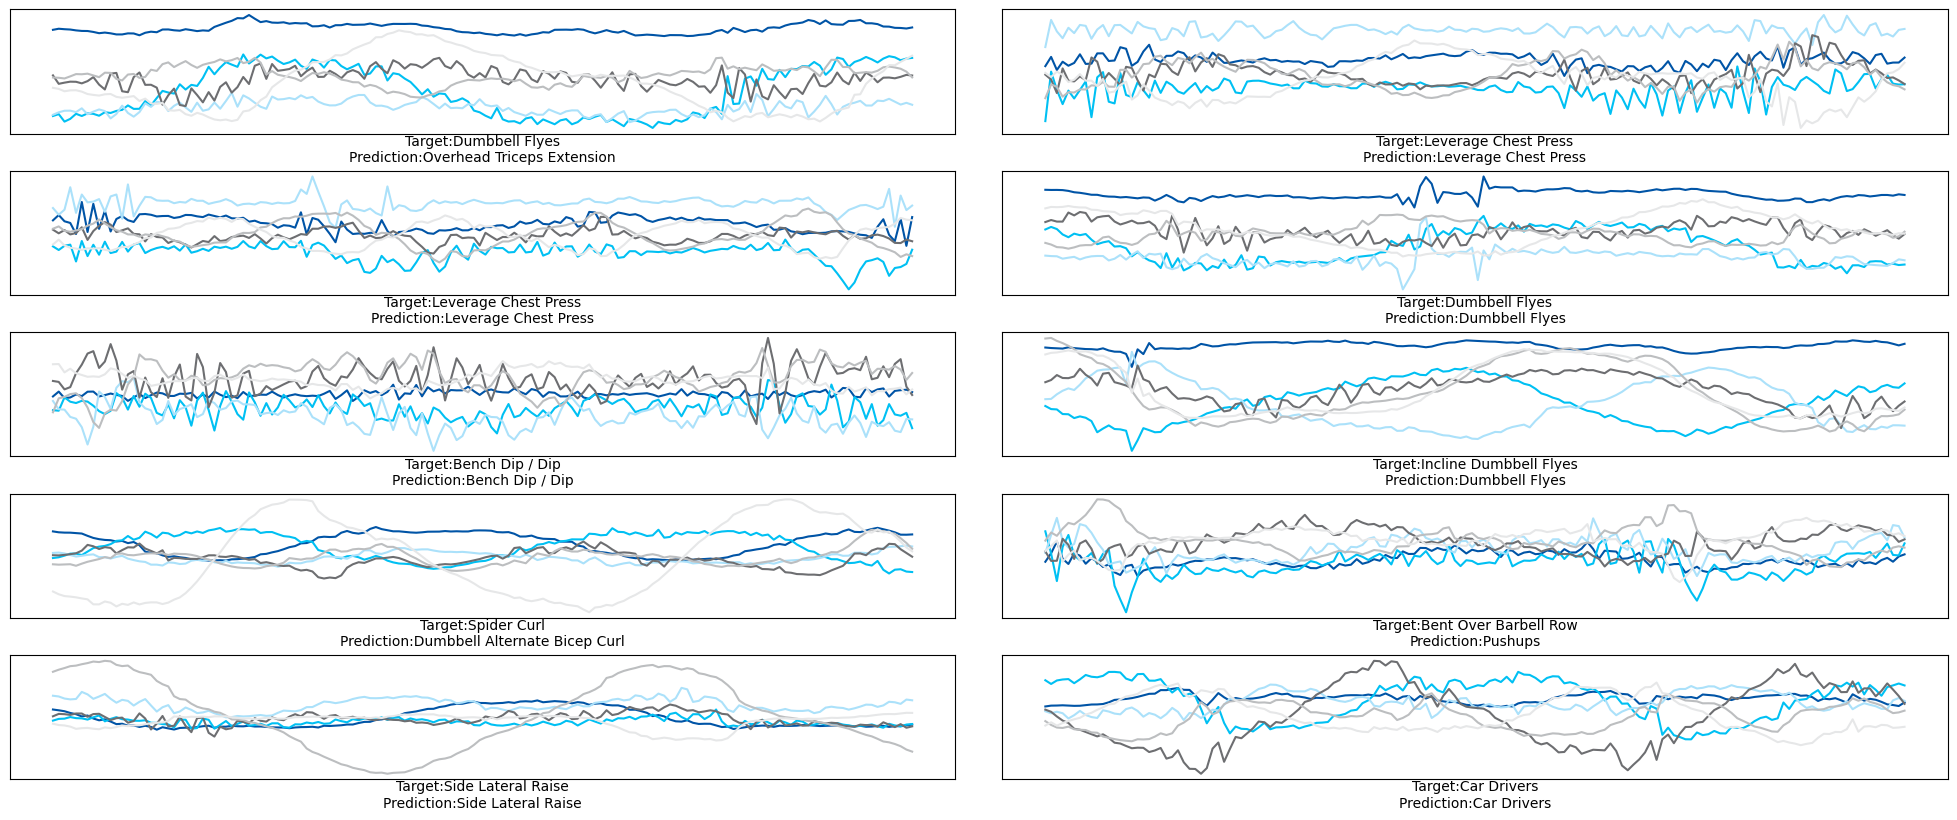

In [35]:
plot_samples(data = x_test, labels = y_test, predictions = fcn_test_predictions)

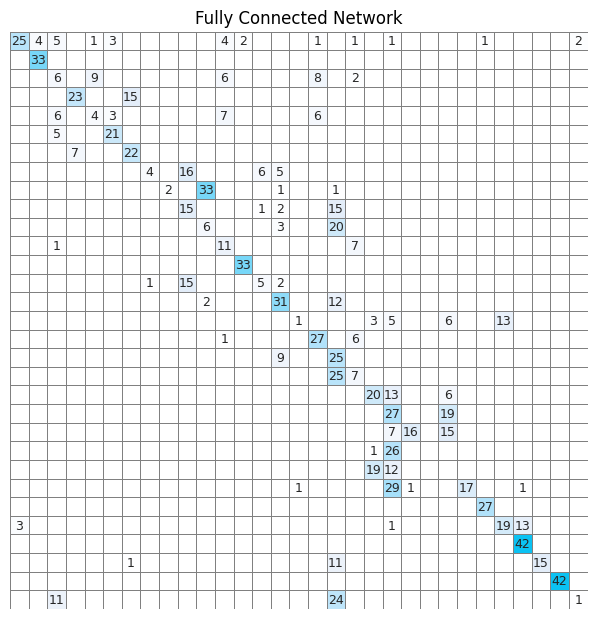

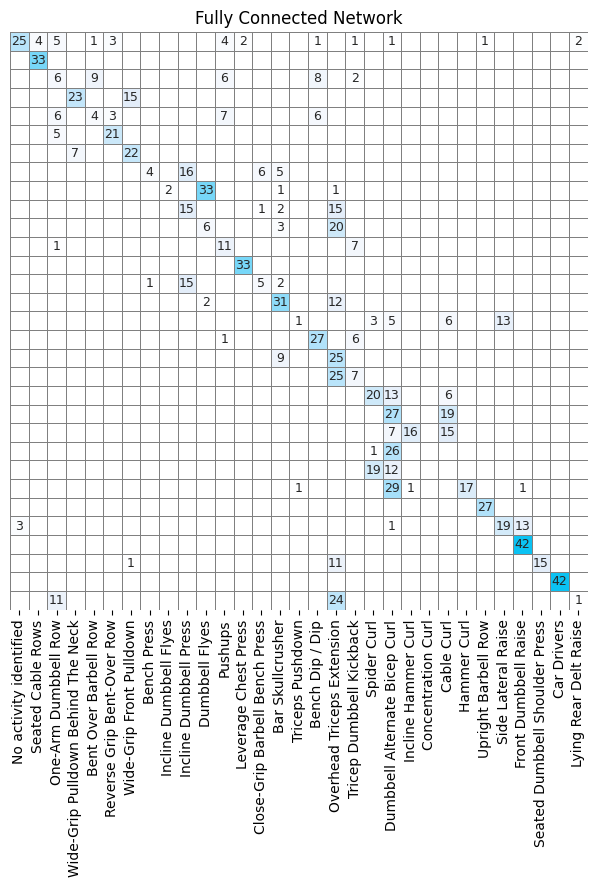

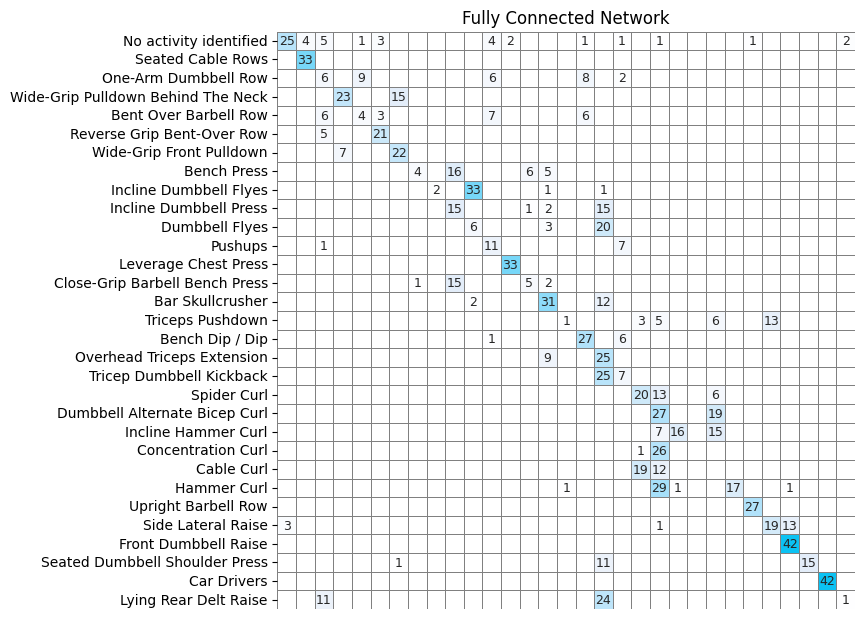

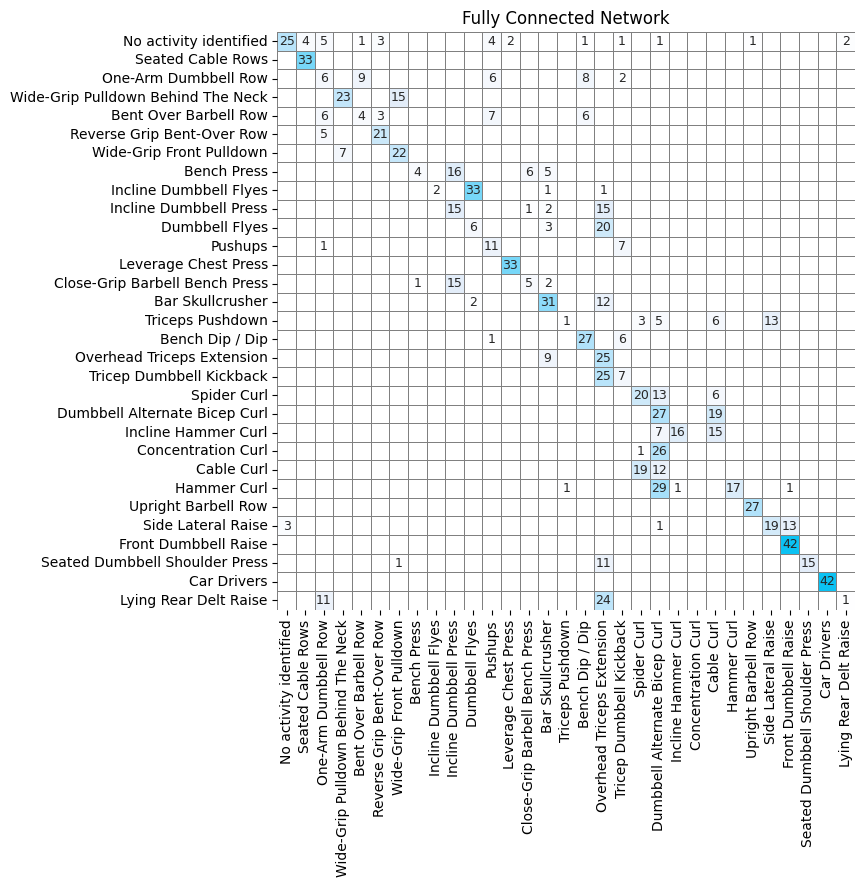

In [17]:
cm = confusion_matrix(y_test, fcn_test_predictions, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm, x_ticks = False, y_ticks = False, save = True, title = "Fully Connected Network")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = False, save = True, title = "Fully Connected Network")
plot_confusion_matrix(cm, x_ticks = False, y_ticks = True, save = True, title = "Fully Connected Network")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = True, save = True, title = "Fully Connected Network")

## **References**

[1] Wang, Zhiguang, Weizhong Yan and Tim Oates. “Time series classification from scratch with deep neural networks: A strong baseline.” 2017 International Joint Conference on Neural Networks (IJCNN) (2016): 1578-1585.